# Peptides encoding (Atchley factors)

In [1]:
import peptides
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from math import sqrt

# libs for ml
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
#from umap import UMAP

# my module with some func
import pepcode

Fetch all cdr3 sequences from VDJdb ver(vdjdb-2024-11-27-fixed) with `cut -f 2 vdjdb-2024-11-27-fixed/vdjdb.slim.txt | grep -v "cdr3" >cdr3_from_VDJdb.txt`

## Set parameters: 

In [3]:
AA_LIST = pepcode.AA_LIST

latent_dims = 200
num_epochs = 500 
batch_size = 1000
learning_rate = 1e-3 
use_gpu = True

# Device set
if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda:0")
elif use_gpu and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

### Loading datasets

In [ ]:
data = pd.read_csv('./dataset/vdjdb-2024-11-27-fixed/vdjdb.slim.txt', sep = '\t')
data = data[(data.gene == 'TRB') & (data.species == 'HomoSapiens')]
data.reset_index(drop=True, inplace=True)
index_list = []
for i in range(len(data)):
    if len(data.iloc[i].cdr3)==15 and data.iloc[i].cdr3[0]=='C' and (data.iloc[i].cdr3[-1]=='F' or data.iloc[i].cdr3[-1]=='W'):
        continue
    else:
        index_list.append(i)
data.drop(index=index_list, inplace=True)
data.reset_index(drop=True, inplace=True)
data = shuffle(data)

#Split dataset and prepare train, test, evaluation datasets
train_size, test_size, eval_size = int(round(len(data)*0.7, 0)), int(round(len(data)*(0.7+0.15), 0)), int(round(len(data)*(1), 0))
data_split = np.split(data, [train_size, test_size, eval_size], axis=0)
data_train = data_split[0]
data_test = data_split[1]
data_eval = data_split[2]

# Prepare peptide lists
pep_train_list = data_train.cdr3.values
pep_test_list = data_test.cdr3.values
pep_eval_list = data_eval.cdr3.values

len_seq = len(pep_train_list[0])


pep_train_af = np.zeros((len(pep_train_list), 5, len_seq), dtype = np.float32)
for i in range(len(pep_train_oh)):
    pep_train_af[i] = pepcode.atchley_factors_code(pep_train_list[i])

pep_test_af = np.zeros((len(pep_test_list), 5, len_seq), dtype = np.float32)
for i in range(len(pep_test_list)):
    pep_test_af[i] = pepcode.atchley_factors_code(pep_test_list[i])   


af_matr_size = pep_test_oh[0].size

# Пока не нужно
pep_eval_af = np.zeros((len(pep_eval_list), 5, len_seq), dtype = np.float32)
for i in range(len(pep_eval_list)):
    pep_eval_af[i] = pepcode.atchley_factors_code(pep_eval_list[i])  

# Prepare train dataloader
af_dataset_train = torch.utils.data.TensorDataset(torch.tensor(pep_train_af), torch.tensor(np.ones(pep_train_af.shape[0])))
af_dl_train = torch.utils.data.DataLoader(af_dataset_train, batch_size=batch_size, shuffle=False)

# Prepare test dataloader
af_dataset_test = torch.utils.data.TensorDataset(torch.tensor(pep_test_af), torch.tensor(np.ones(pep_test_af.shape[0])))
af_dl_test= torch.utils.data.DataLoader(af_dataset_test, batch_size=batch_size, shuffle=False)

# Evaluation (пока не нужно)
af_dataset_eval = torch.utils.data.TensorDataset(torch.tensor(pep_eval_af), torch.tensor(np.ones(pep_eval_af.shape[0])))
af_eval_dl = torch.utils.data.DataLoader(af_dataset_eval, batch_size=batch_size, shuffle=False)


## Autoencoder

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(in_features=5*len_seq, out_features=latent_dims)
            
    def forward(self, x):
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=latent_dims, out_features=5*len_seq)
            
    def forward(self, x):
        x = self.fc(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1sm= Autoencoder()

autoencoder_1sm = autoencoder_1sm.to(device)

num_params = sum(p.numel() for p in autoencoder_1sm.parameters() if p.requires_grad)
print('Number of parameters for Atchley factors encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1sm.parameters(), lr = learning_rate, weight_decay = 1e-5)

Number of parameters for Atchley factors encoding: 7625


### Train autoencoder

In [10]:
# set to training mode
autoencoder_1sm.train()

train_loss_avg_1sm = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1sm.append(0)
    num_batches = 0
    
    for pep_batch, _ in af_encoded_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, af_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1sm(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1sm[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1sm[-1] /= num_batches
    #print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1sm[-1]))
print('Train finished')

Training ...
Train finished


### Evaluation

In [11]:
# set to evaluation mode
autoencoder_1sm.eval()
counter = 0

test_loss_avg, num_batches = 0, 0
for pep_batch, _ in af_encoded_dl_test:
    
    with torch.no_grad():

        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, af_matr_size)

        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1sm(pep_batch)

        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)

        if counter == 0:
            eval_bef_1sm = pep_batch[0].reshape(5, len_seq)
            eval_err_1sm = loss.item()
            eval_aft_1sm = pep_batch_recon[0].reshape(5, len_seq)
            counter +=1

        test_loss_avg += loss.item()
        num_batches += 1
        
    
test_loss_avg /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg))

Average reconstruction error: 0.069945


## Autoencoder_1SB definition (1 layer, Sigmoid, BCE loss)

In [12]:
autoencoder_1sb = Autoencoder()

autoencoder_1sb = autoencoder_1sb.to(device)

num_params = sum(p.numel() for p in autoencoder_1sb.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

loss_function = nn.BCELoss()

optimizer = torch.optim.Adam(autoencoder_1sb.parameters(), lr = learning_rate, weight_decay = 1e-5)

Number of parameters: 7625


### Train autoencoder

In [13]:
autoencoder_1sb.train()

train_loss_avg_1sb = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1sb.append(0)
    num_batches = 0
    
    for pep_batch, _ in af_encoded_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, af_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1sb(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1sb[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1sb[-1] /= num_batches
    #print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
print('Train finished')

Training ...
Train finished


### Evaluation

In [14]:
# set to evaluation mode
autoencoder_1sb.eval()
counter = 0

test_loss_avg, num_batches = 0, 0
for pep_batch, _ in af_encoded_dl_test:
    
    with torch.no_grad():

        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, af_matr_size)

        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1sb(pep_batch)

        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)

        if counter == 0:
            eval_bef_1sb = pep_batch[0].reshape(5, len_seq)
            eval_err_1sb = loss.item()
            eval_aft_1sb = pep_batch_recon[0].reshape(5, len_seq)
            counter +=1

        test_loss_avg += loss.item()
        num_batches += 1
        
    
test_loss_avg /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg))

Average reconstruction error: -72.867603


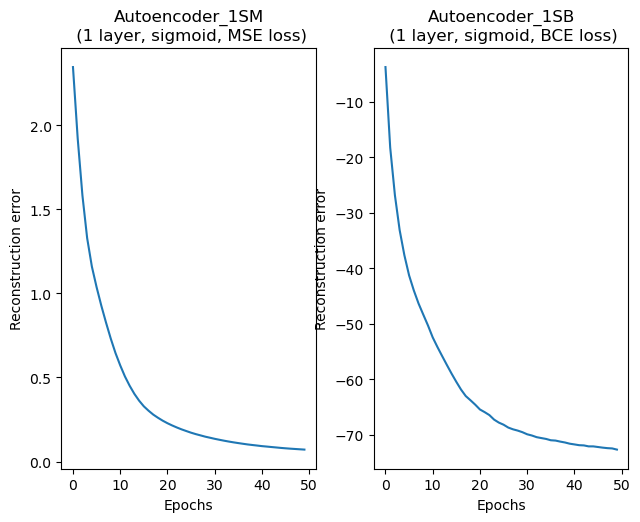

In [15]:
fig, ax = plt.subplots(1, 2)
fig.tight_layout() 

ax[0].plot(train_loss_avg_1sm)
ax[0].set_title("Autoencoder_1SM\n (1 layer, sigmoid, MSE loss)")
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Reconstruction error')

ax[1].plot(train_loss_avg_1sb)
ax[1].set_title("Autoencoder_1SB\n (1 layer, sigmoid, BCE loss)")
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Reconstruction error')

plt.show()

In [18]:
print("Example of reconstructions:")
print("Before autoencoder:\n", eval_bef_1sm)
print("After autoencoder_1sm:\n", eval_aft_1sm)
print("Reconstruction error of 1sm:", eval_err_1sm)
print("After autoencoder_1sb:\n", eval_aft_1sb)
print("Reconstruction error of 1sb:", eval_err_1sb)

Example of reconstructions:
Before autoencoder:
 tensor([[-1.3427, -0.2279, -0.5915,  1.5375,  1.0502, -0.0318, -0.2279, -0.3839,
         -0.2279,  0.2600,  0.9454,  1.3573,  0.9306, -1.0061, -1.0061],
        [ 0.4654,  1.3987, -1.3021, -0.0547,  0.3024,  0.3257,  1.3987,  1.6520,
          1.3987,  0.8299,  0.8285, -1.4528, -0.1793, -0.5905, -0.5905],
        [-0.8620, -4.7596, -0.7331,  1.5021, -3.6559,  2.2135, -4.7596,  1.3301,
         -4.7596,  3.0974,  1.2991,  1.4767, -3.0049,  1.8910,  1.8910],
        [-1.0201,  0.6702,  1.5704,  0.4403, -0.2590,  0.9079,  0.6702,  1.0450,
          0.6702, -0.8380, -0.1688,  0.1129, -0.5026, -0.3966, -0.3966],
        [-0.2552, -2.6475, -0.1455,  2.8974, -3.2418,  1.3134, -2.6475,  2.0639,
         -2.6475,  1.5115,  0.9334, -0.8372, -1.8530,  0.4119,  0.4119]],
       device='mps:0')
After autoencoder_1sm:
 tensor([[-1.3985, -0.3476, -0.8803,  1.4518,  1.0338, -0.1294, -0.1408, -0.3265,
         -0.3167,  0.4668,  0.6836,  1.3776,  1.0289